In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/data.csv')
StarPlayer = pd.read_csv('../data/StarPlayer.csv')
StarPres = pd.read_csv('../data/StarPresence.csv')

In [6]:
# create numstars
numstars = (StarPlayer.groupby(['Year','Team'])
                  .size()
                  .reset_index(name='NumStars')\
                    .fillna({'NumStars': 0}))
numstars.head()

,Year,Team,NumStars
0,2011,Atlanta Hawks,1
1,2011,Chicago Bulls,1
2,2011,Dallas Mavericks,1
3,2011,Los Angeles Lakers,2
4,2011,Menphis Grizzlies,1


In [ ]:
# merge star player and star presence
star = (df
      .merge(StarPres, on=['Year','Team'], how='left')
      .merge(numstars, on=['Year','Team'], how='left'))

# fillna and convert to int
star[['StarPresence','NumStars']] = star[['StarPresence','NumStars']].fillna(0).astype(int)

In [10]:
# add star arrival
star = star.sort_values(['Team','Year'])
star['StarArrival'] = (
    star.groupby('Team')['StarPresence']
      .diff()               # ΔPresence
      .fillna(0)
      .eq(1)                # True if 0→1
      .astype(int)
)
star.to_csv('../data/data_star.csv', index=False)

In [11]:
df = pd.read_csv('../data/data_star.csv')

## EDA

In [15]:
df.describe()

,Year,Valuation,CPI,RealValuation,LogValuation,StarArrival,StarPresence,NumStars
count,465.000000,4.650000e+02,465.000000,4.650000e+02,465.000000,465.000000,465.000000,465.000000
mean,2018.000000,1.806547e+09,261.086667,2.100833e+09,21.209214,0.131183,0.380645,0.468817
std,4.325147,1.452917e+09,31.246709,1.494058e+09,0.745110,0.337964,0.486068,0.665980
min,2011.000000,2.580000e+08,224.900000,3.697350e+08,19.728297,0.000000,0.000000,0.000000
25%,2014.000000,7.200000e+08,236.700000,9.669000e+08,20.689606,0.000000,0.000000,0.000000
50%,2018.000000,1.450000e+09,251.100000,1.766462e+09,21.292245,0.000000,0.000000,0.000000
75%,2022.000000,2.500000e+09,292.700000,2.973044e+09,21.812852,0.000000,1.000000,1.000000
max,2025.000000,8.800000e+09,322.300000,8.800000e+09,22.898018,1.000000,1.000000,3.000000


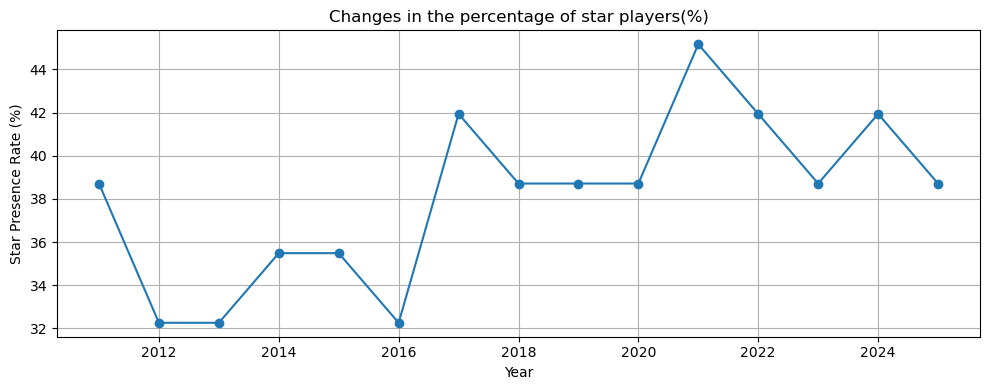

In [16]:
star_rate = df.groupby("Year")["StarPresence"].mean() * 100

plt.figure(figsize=(10, 4))
plt.plot(star_rate.index, star_rate.values, marker="o")
plt.title("Changes in the percentage of star players(%)")
plt.xlabel("Year")
plt.ylabel("Star Presence Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

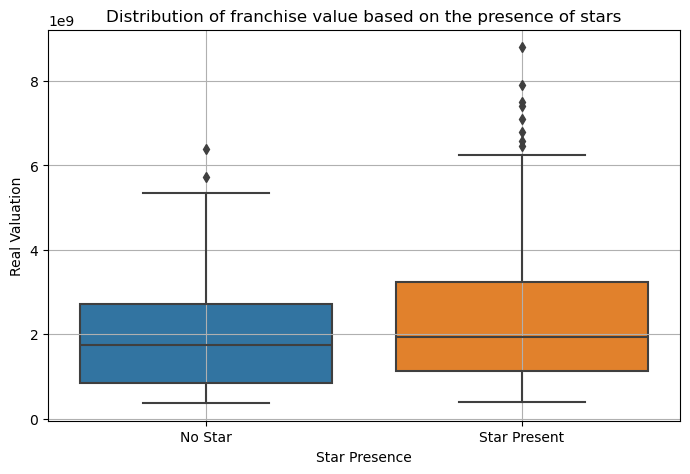

In [17]:
plt.figure(figsize=(7, 5))
sns.boxplot(x="StarPresence", y="RealValuation", data=df)
plt.xticks([0, 1], ["No Star", "Star Present"])
plt.title("Distribution of franchise value based on the presence of stars")
plt.xlabel("Star Presence")
plt.ylabel("Real Valuation")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import statsmodels.formula.api as smf

m1 = smf.ols("LogValuation ~ StarPresence + C(Team) + C(Year)", data=df)\
        .fit(cov_type="cluster", cov_kwds={"groups": df["Team"]})

m1.summary().tables[1]

c:\Users\shoku\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 45, but rank is 15
  warnings.warn('covariance of constraints does not have full '


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,19.7765,0.035,568.279,0.000,19.708,19.845
C(Team)[T.Boston Celtics],0.6883,0.009,75.928,0.000,0.671,0.706
C(Team)[T.Brooklyn Nets],0.4976,0.001,384.245,0.000,0.495,0.500
C(Team)[T.Charlotte Hornets],-0.0660,0.001,-50.958,0.000,-0.069,-0.063
C(Team)[T.Chicago Bulls],0.7614,0.001,587.984,0.000,0.759,0.764
C(Team)[T.Cleveland Cavaliers],0.1148,0.004,29.545,0.000,0.107,0.122
C(Team)[T.Dallas Mavericks],0.4739,0.005,91.483,0.000,0.464,0.484
C(Team)[T.Denver Nuggets],0.0581,0.005,11.219,0.000,0.048,0.068
C(Team)[T.Detroit Pistons],0.0192,5.3e-14,3.61e+11,0.000,0.019,0.019
C(Team)[T.Golden State Warriors],0.8184,0.012,70.215,0.000,0.796,0.841


In [19]:
m2 = smf.ols("LogValuation ~ StarArrival + StarPresence + C(Team) + C(Year)", data=df)\
        .fit(cov_type="cluster", cov_kwds={"groups": df["Team"]})

m2.summary().tables[1]


c:\Users\shoku\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 46, but rank is 16
  warnings.warn('covariance of constraints does not have full '


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,19.7714,0.035,569.694,0.000,19.703,19.839
C(Team)[T.Boston Celtics],0.6766,0.013,51.950,0.000,0.651,0.702
C(Team)[T.Brooklyn Nets],0.4953,0.001,534.635,0.000,0.493,0.497
C(Team)[T.Charlotte Hornets],-0.0643,0.002,-34.569,0.000,-0.068,-0.061
C(Team)[T.Chicago Bulls],0.7638,0.001,824.435,0.000,0.762,0.766
C(Team)[T.Cleveland Cavaliers],0.1137,0.004,27.392,0.000,0.106,0.122
C(Team)[T.Dallas Mavericks],0.4632,0.009,51.452,0.000,0.446,0.481
C(Team)[T.Denver Nuggets],0.0474,0.009,5.269,0.000,0.030,0.065
C(Team)[T.Detroit Pistons],0.0231,0.002,13.256,0.000,0.020,0.027
C(Team)[T.Golden State Warriors],0.8033,0.017,47.973,0.000,0.770,0.836


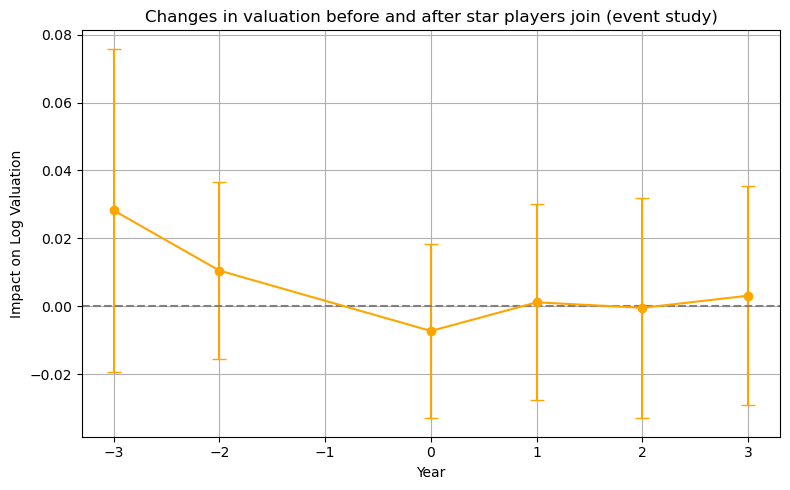

In [26]:
# 1. StarArrivalのある年を抽出し、ArrivalYearとして追加
arrival_years = df[df["StarArrival"] == 1][["Team", "Year"]].rename(columns={"Year": "ArrivalYear"})
es = df.merge(arrival_years, on="Team", how="left")

# 2. 相対年 k を計算
es["k"] = es["Year"] - es["ArrivalYear"]

# 3. -3〜+3年に絞る
es = es[es["k"].between(-3, 3)]

# 4. Dummy変数の作成（マイナス記号を変換）
for i in [-3, -2, 0, 1, 2, 3]:
    col_name = f"D_minus{abs(i)}" if i < 0 else f"D_{i}"
    es[col_name] = (es["k"] == i).astype(int)

# 5. 回帰式とモデル
dummies = [f"D_minus{abs(i)}" if i < 0 else f"D_{i}" for i in [-3, -2, 0, 1, 2, 3]]
fmla = "LogValuation ~ " + " + ".join(dummies) + " + C(Team) + C(Year)"
m_es = smf.ols(fmla, data=es).fit(cov_type="cluster", cov_kwds={"groups": es["Team"]})

# 6. 回帰結果のプロット
coefs = m_es.params[dummies]
errs = m_es.bse[dummies]
x_vals = [-3, -2, 0, 1, 2, 3]

plt.figure(figsize=(8, 5))
plt.errorbar(x_vals, coefs, yerr=1.96 * errs, fmt="o-", capsize=5, color='orange')
plt.axhline(0, color="gray", linestyle="--")
plt.title("Changes in valuation before and after star players join (event study)")
plt.xlabel("Year")
plt.ylabel("Impact on Log Valuation")
plt.grid(True)
plt.tight_layout()
plt.show()
